In [1]:
import os, sys
import pandas as pd
import pickle
import utils as utils
import torch
import numpy as np
sys.path.insert(1, '../')
from speed_predictor import preprocess_data, preprocess_df

import warnings
warnings.filterwarnings("ignore")

from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

In [2]:
torch.manual_seed(42)
np.random.seed(42)

In [3]:
test_data_pth = 'data/test2'
test_files = [os.path.join(test_data_pth, fn) for fn in os.listdir(test_data_pth)]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
with open(os.path.join('data', 'min_max_scaler'), 'rb') as file:
        scaler = pickle.load(file)
params = {
    'FW_SAMPLES': 35, 
    'BW_SAMPLES': 25, 
    'n_layers': 5, 
    'activation': 'ELU',
}
input_shape = (params['FW_SAMPLES'] + params['BW_SAMPLES'] + 1) * 42

In [4]:
class Object(object):
    pass

a = Object()
a.params = params
a.value = 0.06777518826632188

model = utils.load_eval_model(a, 'experimenty/04_mlp_flatten', input_shape, device)

In [17]:
fu = []

In [ ]:
for tf in test_files[:]:
    df = pd.read_csv(tf, index_col='index')
    X, _ = preprocess_data(df, params, scaler)
    X = torch.tensor(X)
    ig = IntegratedGradients(model)
    ig_attr_test = ig.attribute(X, n_steps=10)
    ig_attr_test_sum = ig_attr_test.detach().numpy().sum(0)
    ig_attr_test_norm_sum = ig_attr_test_sum / np.linalg.norm(ig_attr_test_sum, ord=1)
    #fu.append(ig_attr_test_sum)
    with open(f'vis_{tf.split("/")[-1]}.pickle', 'wb') as f:
        pickle.dump(ig_attr_test_sum, f)

In [18]:
import os
vis = [fn for fn in os.listdir('.') if fn.startswith('vis_')]

In [19]:
sums = []
import pickle
for v in vis:
    with open(v, 'rb') as f:
        suma = pickle.load(f)
        sums.append(suma)

In [43]:
total = sums[0]
for suma in sums[1:]:
    total += suma

In [44]:
total.shape

(61, 42)

In [22]:
df = pd.read_csv(test_files[0], index_col='index')

In [23]:
df = preprocess_df(df)

In [24]:
len(list(df.columns))

43

In [25]:
import numpy as np
total2 = total / np.linalg.norm(total, ord=1)

In [33]:
total = total.T

In [45]:
total[0].min()

-320.9019556944717

In [49]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

total3 = scaler.fit_transform(total)

In [50]:
total3[0].max()

1.0000000000000002

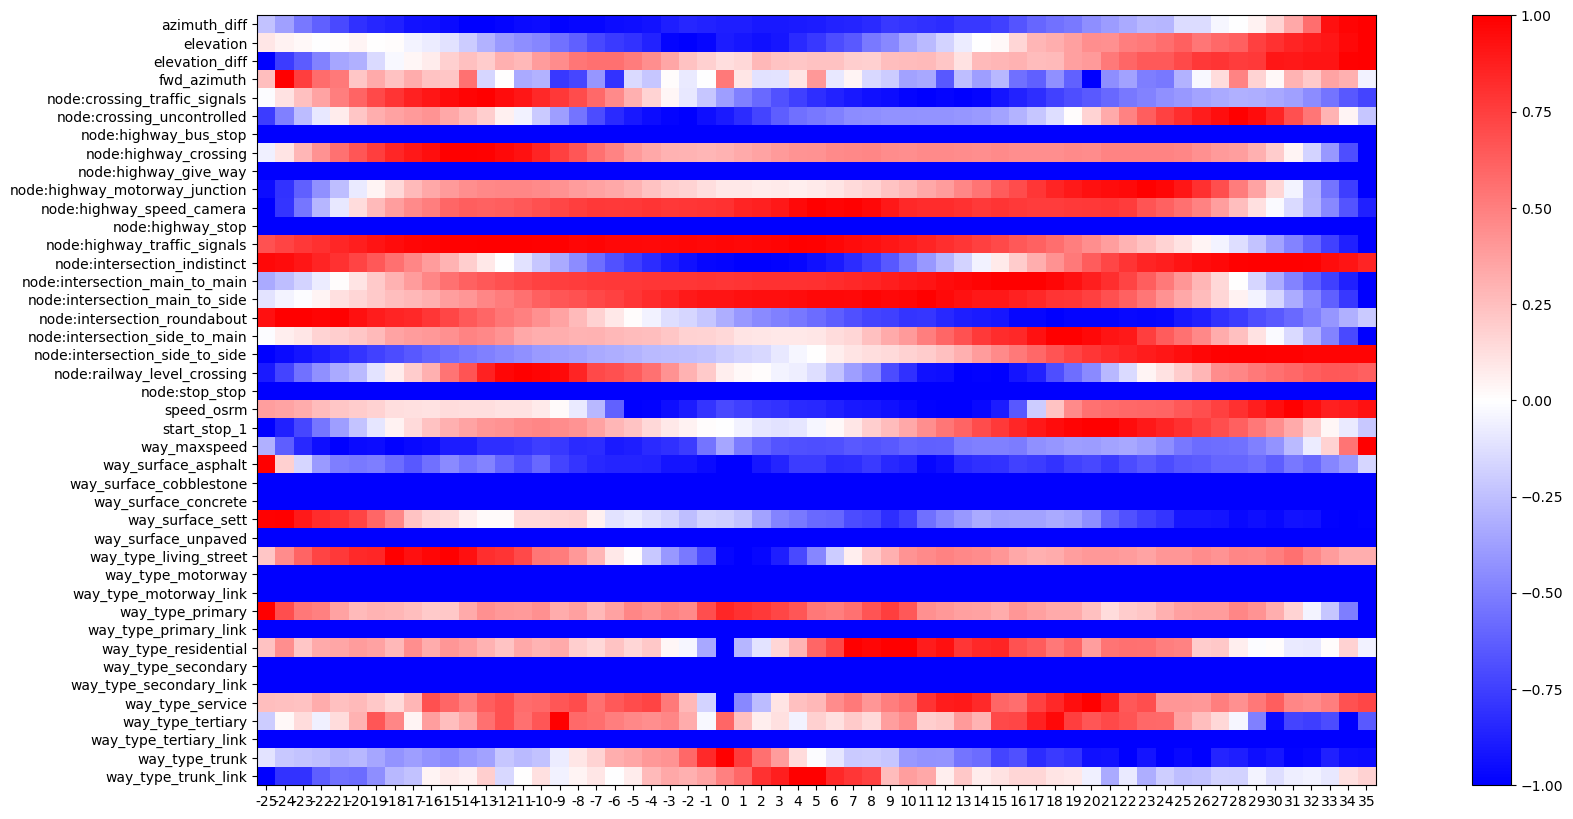

In [53]:
import matplotlib.pyplot as plt
#import seaborn as sns
plt.figure(figsize=(25, 10))
plt.imshow(total3.T, cmap='bwr', interpolation='nearest')
#ax = sns.heatmap(ig_attr_test_norm_sum, linewidth=0.5)
plt.xticks(np.arange(61), np.arange(-25, 36).astype('str'))
plt.yticks(np.arange(42), list(df.columns)[1:])
plt.colorbar()
plt.show()